In [1]:
import sys, cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import collections
from dataclasses import dataclass
from tqdm.notebook import tnrange, tqdm
from functools import reduce

# Reading Dumped data

In [2]:
with open('sortedFish.pik','rb') as f:
    sortedFish=pickle.load(f)

posU=sortedFish[0]
nonOverlappingRange=sortedFish[1]
fishU=sortedFish[2]

fishU=frame,fish,pixel,[row,col,grey]

262 30 113.57956808685125 111.0


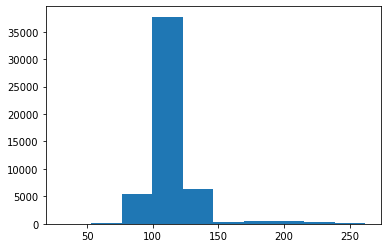

(array([    0,     1,     2, ..., 51211, 51212, 51213], dtype=int64),)


In [3]:
# Pixels should be over 150, here's how many are.
pixelCount=[]
for i in range(len(fishU)):
    pixelCount.append(len(fishU[i][0]))
print(max(pixelCount),min(pixelCount),np.mean(pixelCount),np.median(pixelCount))
plt.hist(pixelCount)
plt.show()
pixelCount=np.array(pixelCount)
print(np.where(pixelCount<150))

# Creating a distance histogram out of the sorted data

### Function to create histograms

In [4]:
def histMaker(histData,bins1,bins2):
    '''
    Creates a 2d histogram.
    
    Input:
        histData:Either histSum or histDif. Some sort of array?
        bins1:The distance bins. np.linspace(int,int,int)
        bins2:The sum/difference bins. np.linspace(int,int,int)
    '''
    #fig=plt.figure(figsize=(5,5))
    
    plt.imshow(histData[:,::-1].T,extent=[bins1[0], bins1[-1], bins2[0], bins2[-1]],aspect='auto')
    plt.colorbar()
    
    #plt.show()

### Creating histograms for two fish over the first n nonoverlapping ranges.

The following 4 cells are 3 different ways of setting the bins that the histograms use. Todo: chose a method that works the best.

In [5]:
binsDist=np.linspace(0,30,30)
binsDif=np.linspace(0,50,50)
binsSum=np.linspace(150,350,200)
histSum=np.zeros((len(binsDist)-1,len(binsSum)-1))
histDif=np.zeros((len(binsDist)-1,len(binsDif)-1))

*Reenable this cell*

This cell creates the histograms from the data. It loops over the number of nonoverlapping ranges and provides a histogram of the brightness sum and difference for each fish.

The end of the previous cell writes the data to histLists.pik, so this cell reads back the data.

In [6]:
with open('histLists.pik','rb') as f:
    histLists=pickle.load(f)

#globals().update(histLists)
histSumList=histLists[0]
histDifList=histLists[1]

*Reenable this cell*

This cell creates visual forms of the histogram data.

### Checking distances between the histograms

Use scipy.spatial.distance.cdist instead?

In [7]:
def swapStatus(histList):
    '''
    Detext swaps between consecutive nonOverlappingRanges based on brightness sum and difference by using a distance matrix.
    
    Input:
        histList: . Dictionary
    
    Output:
        Int. 0 if no swaps, 1 if swapped, 2 if overlapping.
    '''
    
    #histList=list(histDict.values())
    
    distanceMatrix=[np.linalg.norm(histList[0,0]-histList[1,0]),
        np.linalg.norm(histList[1,0]-histList[1,1]),
        np.linalg.norm(histList[0,1]-histList[1,0]),
        np.linalg.norm(histList[0,1]-histList[1,1])]
    
    swapCriteron=(distanceMatrix[0]+distanceMatrix[1])-(distanceMatrix[2]+distanceMatrix[3])
    if abs(swapCriteron)<1e-10:
        return 2 #Overlapping
    elif swapCriteron>0:
        return 1 #Swapped
    elif swapCriteron<0:
        return 0 #Normal
    else:
        return -1

In [8]:
swapStatus(histSumList)

1

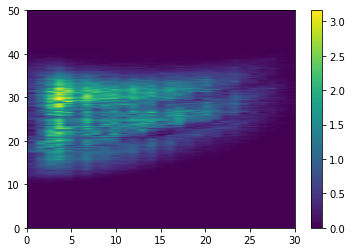

In [9]:
dH=np.mean([np.absolute(histSumList[i,0]-histSumList[0,1]) for i in range(2)],axis=0)
histMaker(dH,binsDist,binsDif)
plt.show()

H=histSumList
distMat=np.array([[H[1,0]-H[0,0],H[1,0]-H[0,1]],
                 [H[1,1]-H[0,0],H[1,1]-H[0,1]]])
#multiply by dH, sum

# Creates graphs of the on and off axis distances to allow for visual comparing of where one excedes the other

In [10]:
def swapMatrix(histList):
    '''
    Creates a list of pairs consisting of the onAxxiss distance and the off axis distance for a given set of histograms.
    
    Input:
    
    Output: [[,],[,]]
    '''
    nOverlap=list(histList.keys())[-1][0]
    
    distanceMatrix=[]
    for i in range(nOverlap):
        distSame=np.linalg.norm(histList[i+1,0]-histList[i,0])+np.linalg.norm(histList[i+1,1]-histList[i,1])
        distDiff=np.linalg.norm(histList[i+1,1]-histList[i,0])+np.linalg.norm(histList[i+1,0]-histList[i,1])
        distanceMatrix.append([distSame,distDiff])
    
    return(np.array(distanceMatrix).T)

Loads in the maunal results

In [11]:
# 1 is swap, 0 isn't.
f=open('overlapCheck.txt','r')
next(f)
manualOverlapArray=[]
for line in f:
    line=line.strip().split(',')
    manualOverlapArray.append([int(x) for x in line ])
    
manualOverlapList=[]
for i in range(len(manualOverlapArray)):
    if manualOverlapArray[i][1]==1:
        manualOverlapList.append(manualOverlapArray[i][0])
        #Check this???
print(manualOverlapArray)
print(manualOverlapList)

[[0, 1], [1, 0], [2, 0], [3, 1], [4, 0], [5, 0], [6, 0], [7, 1], [8, 0], [9, 0], [10, 0], [11, 0], [12, 1], [13, 0], [14, 1], [15, 1], [16, 0], [17, 0], [18, 0], [19, 0], [20, 0], [21, 1], [22, 0], [23, 0], [24, 0], [25, 1], [26, 1], [27, 0], [28, 0], [29, 0], [30, 1], [31, 0], [32, 1], [33, 1], [34, 0], [35, 0], [36, 0], [37, 0], [38, 0], [39, 0], [40, 1], [41, 1], [42, 0], [43, 1], [44, 1], [45, 0], [46, 0], [47, 0], [48, 0], [49, 0], [50, 1], [51, 1], [52, 0], [53, 1], [54, 1], [55, 0], [56, 1], [57, 1], [58, 1], [59, 0]]
[0, 3, 7, 12, 14, 15, 21, 25, 26, 30, 32, 33, 40, 41, 43, 44, 50, 51, 53, 54, 56, 57, 58]


In [12]:
def swapLister(distanceMatrix):
    '''
    Displays a list of all the nonoverlapping ranges in which swaps occur according to the on/off axis distances of the imput matricies.
    
    '''
    swapList=[]
    
    for i in range(len(distanceMatrix.T)):
        if distanceMatrix[1,i]<distanceMatrix[0,i]:
            swapList.append(i)
        
    return(swapList)

### Sum histograms

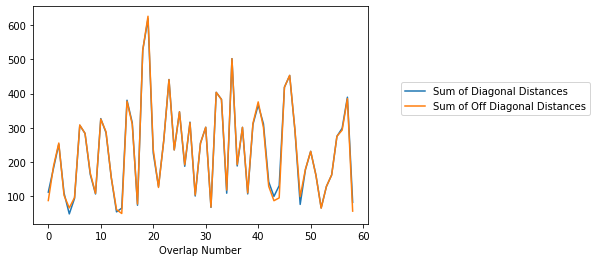

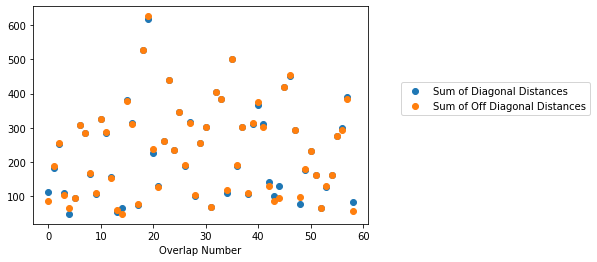

In [13]:
distanceMatrix=swapMatrix(histSumList)

plt.plot(distanceMatrix[0],label='Sum of Diagonal Distances')
plt.plot(distanceMatrix[1],label='Sum of Off Diagonal Distances')
plt.xlabel('Overlap Number')
plt.legend(loc=(1.1,.5))
plt.show()

plt.scatter(np.linspace(0,len(distanceMatrix[0])-1,len(distanceMatrix[0])),distanceMatrix[0],label='Sum of Diagonal Distances')
plt.scatter(np.linspace(0,len(distanceMatrix[1])-1,len(distanceMatrix[1])),distanceMatrix[1],label='Sum of Off Diagonal Distances')
plt.xlabel('Overlap Number')
plt.legend(loc=(1.1,.5))
plt.show()

In [14]:
print(swapLister(swapMatrix(histSumList)))
print(manualOverlapList)
print("Same",np.intersect1d(swapLister(swapMatrix(histSumList)),manualOverlapList))
print("Difference",set(swapLister(swapMatrix(histSumList)))^set(manualOverlapList))

[0, 3, 7, 10, 12, 14, 15, 16, 18, 21, 22, 23, 24, 25, 27, 29, 30, 32, 33, 35, 41, 42, 43, 44, 45, 50, 51, 52, 54, 55, 56, 57, 58]
[0, 3, 7, 12, 14, 15, 21, 25, 26, 30, 32, 33, 40, 41, 43, 44, 50, 51, 53, 54, 56, 57, 58]
Same [ 0  3  7 12 14 15 21 25 30 32 33 41 43 44 50 51 54 56 57 58]
Difference {10, 16, 18, 22, 23, 24, 26, 27, 29, 35, 40, 42, 45, 52, 53, 55}


### Difference histograms

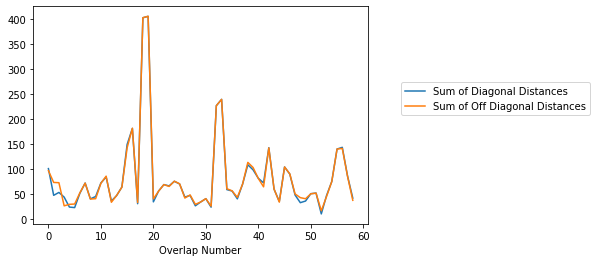

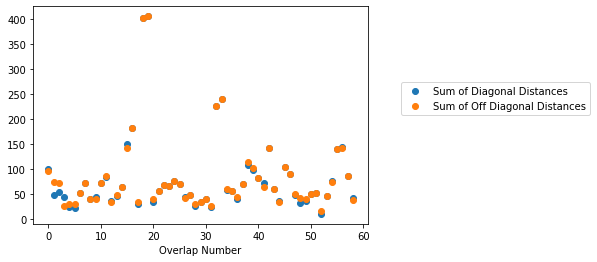

In [15]:
distanceMatrix=swapMatrix(histDifList)

plt.plot(distanceMatrix[0],label='Sum of Diagonal Distances')
plt.plot(distanceMatrix[1],label='Sum of Off Diagonal Distances')
plt.xlabel('Overlap Number')
plt.legend(loc=(1.1,.5))
plt.show()

plt.scatter(np.linspace(0,len(distanceMatrix[0])-1,len(distanceMatrix[0])),distanceMatrix[0],label='Sum of Diagonal Distances')
plt.scatter(np.linspace(0,len(distanceMatrix[1])-1,len(distanceMatrix[1])),distanceMatrix[1],label='Sum of Off Diagonal Distances')
plt.xlabel('Overlap Number')
plt.legend(loc=(1.1,.5))
plt.show()

In [16]:
print(swapLister(swapMatrix(histDifList)))
print(manualOverlapList)
print("Similarities",np.intersect1d(swapLister(swapMatrix(histDifList)),manualOverlapList))
print("Difference",set(swapLister(swapMatrix(histDifList)))^set(manualOverlapList))

[0, 3, 7, 8, 9, 10, 12, 14, 15, 21, 22, 23, 26, 29, 30, 32, 33, 40, 41, 42, 44, 45, 50, 51, 53, 54, 55, 56, 57, 58]
[0, 3, 7, 12, 14, 15, 21, 25, 26, 30, 32, 33, 40, 41, 43, 44, 50, 51, 53, 54, 56, 57, 58]
Similarities [ 0  3  7 12 14 15 21 26 30 32 33 40 41 44 50 51 53 54 56 57 58]
Difference {8, 9, 10, 22, 23, 25, 29, 42, 43, 45, 55}


#### Finds differences/intersections between the sum and difference swap sets

In [17]:
print(set(swapLister(swapMatrix(histSumList)))^set(swapLister(swapMatrix(histDifList))))

{8, 9, 16, 18, 24, 25, 26, 27, 35, 40, 43, 52, 53}


In [18]:
print((reduce(np.intersect1d,(swapLister(swapMatrix(histDifList)),swapLister(swapMatrix(histSumList))))))
print(reduce(np.intersect1d,(swapLister(swapMatrix(histDifList)),swapLister(swapMatrix(histSumList)),manualOverlapList)))
print(set(reduce(np.intersect1d,(swapLister(swapMatrix(histDifList)),swapLister(swapMatrix(histSumList)))))^set(manualOverlapList))

[ 0  3  7 10 12 14 15 21 22 23 29 30 32 33 41 42 44 45 50 51 54 55 56 57
 58]
[ 0  3  7 12 14 15 21 30 32 33 41 44 50 51 54 56 57 58]
{10, 22, 23, 25, 26, 29, 40, 42, 43, 45, 53, 55}


## Allow definitions of custom  bins.

In [19]:
def binReducer(x,bX,bY,n):
    '''
    Takes histogram data and reduces the number of bins by the imputed amount.
    
    Input: 
        x: Raw histogram data
        bX: Bins for the X axis
        bY: Bins for the Y axis
        n: Factor by which to reduce the histogram
        
    Output:
        A histogram
    '''
    
    x=x.copy()
    
    m0=x.shape[0]//n
    m1=x.shape[1]//n
    #print(m0,m1)
    output=np.zeros((m0,m1))
    
    for i in range(n):
        #print("x",x.shape)
        while ((x.shape[1]%n!=0)|(x.shape[0]%n!=0)):
            #print("\t loop",((x.shape[1]%n!=0)&(x.shape[0]%n!=0)))
            if(x.shape[0]%n!=0):
                x[-2,:]=x[-1,:]+x[-2,:]
                x=np.delete(x,-1,0)
                #print("\t",x.shape)

            if(x.shape[1]%n!=0):
                x[:,-2]=x[:,-1]+x[:,-2]
                x=x[:,:-1]
                #print("\t",x.shape)
            #print("\t",((x.shape[1]%n!=0)&(x.shape[0]%n!=0)))

        #print("not loop")    
        output[:,:]+=x[i::n,i::n]
        #print("output",output.shape)
        
        binsX=bX[::3]
        binsY=bY[::3]
        
        return output,binsX,binsY

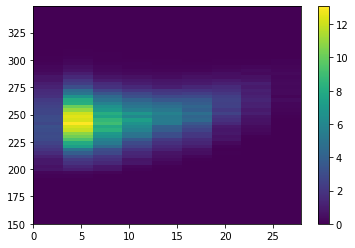

In [20]:
histMaker(*binReducer(histSumList[0,0],binsDist,binsSum,3))

## Find if bin reduction has effect on accuracy of overlap detection
Creates a function that combines the previous two sections

In [59]:
def histThing(data,bins,n):
    '''
    Function that simulates reducing the bins on the histograms and displays the error resulting from that opperation.
    
    Input:
        data: either histSumList or histDifList
        bins: either binsSum or binsDif deppending on data
        n: number of reductions performed
        
    Output: Histograms of the reductions of data[0,0], a list of overlaps for each reduction and accompning visual scatterplot, and the error from each reduction commpared to unreduced.
    '''
    
    plt.figure(figsize=(7*n,10))
    plt.suptitle('Reduction of data[0,0]',ha='center',size='xx-large')
    plt.subplot(1,n+1,1)
    histMaker(data[0,0],binsDist,bins)
    plt.title('Original')
    for i in range(1,n+1):
        plt.subplot(2,n+1,i)
        histMaker(*binReducer(data[0,0],binsDist,bins,i))
        plt.title('Reduced by a factor of {}'.format(i))
    plt.show()
    
    reducedSwap = {}
    
    plt.figure(figsize=(7*n,10))
    plt.suptitle('Overlap checks for various reductions',ha='center',size='xx-large')
    for i in range(1,n+1):
        histReducedList={}
        for j in range(len(data)//2):
            histReducedList[j,0]=binReducer(data[j,0],binsDist,bins,i)[0]
            histReducedList[j,1]=binReducer(data[j,1],binsDist,bins,i)[0]
        distanceMatrix=swapMatrix(histReducedList)
        
        plt.subplot(2,n+1,i)
        plt.title('Reduced by a factor of {}'.format(i))
        plt.scatter(np.linspace(0,len(distanceMatrix[0])-1,len(distanceMatrix[0])),distanceMatrix[0],label='Sum of Diagonal Distances')
        plt.scatter(np.linspace(0,len(distanceMatrix[1])-1,len(distanceMatrix[1])),distanceMatrix[1],label='Sum of Off Diagonal Distances')
        plt.xlabel('Overlap Number')
        if(i==n):
            plt.legend(loc=(1.1,.5))
        
        print('The overlaps for a reduction of {} are {}'.format(i,swapLister(distanceMatrix)))
        reducedSwap[i]=swapLister(distanceMatrix)
        
    plt.show()
    
    for i in range(1,len(list(reducedSwap.keys()))):
        print("Difference Between Reductions of:",1,i+1,"Difference:",set(reducedSwap[1])^set(reducedSwap[i+1]),"Error:",(len(set(reducedSwap[1])^set(reducedSwap[i+1])))/(len(reducedSwap[1])))
        print("Difference Between Reductions of:","Manual",i+1,"Difference:",set(manualOverlapList)^set(reducedSwap[i+1]),"Error:",(len(set(manualOverlapList)^set(reducedSwap[i+1])))/(len(manualOverlapList)))
        
    print("Difference Between Nonreduced and Manual:",set(reducedSwap[1])^set(manualOverlapList),"Error:",(len(set(reducedSwap[1])^set(manualOverlapList)))/(len(manualOverlapList)))

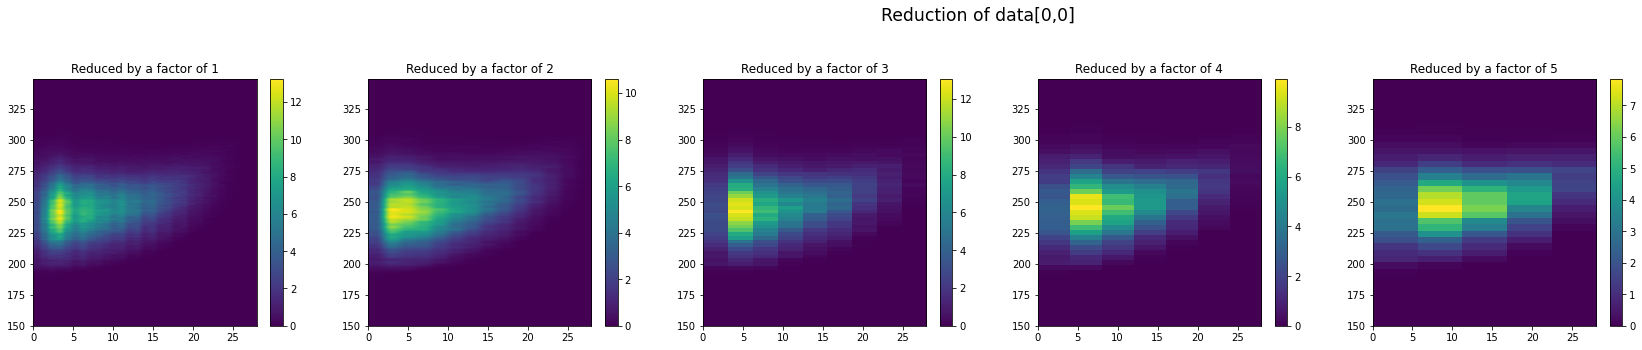

The overlaps for a reduction of 1 are [0, 3, 7, 10, 12, 14, 15, 16, 18, 21, 22, 23, 24, 25, 27, 29, 30, 32, 33, 35, 41, 42, 43, 44, 45, 50, 51, 52, 54, 55, 56, 57, 58]
The overlaps for a reduction of 2 are [0, 3, 7, 10, 12, 14, 15, 16, 18, 21, 22, 23, 24, 25, 27, 29, 30, 32, 33, 35, 41, 42, 43, 44, 45, 50, 51, 52, 54, 55, 56, 57, 58]
The overlaps for a reduction of 3 are [0, 3, 10, 14, 15, 16, 18, 21, 22, 23, 25, 27, 29, 30, 32, 33, 35, 41, 42, 43, 44, 45, 50, 51, 52, 54, 55, 56, 57, 58]
The overlaps for a reduction of 4 are [0, 3, 7, 10, 12, 14, 15, 16, 18, 21, 22, 23, 24, 27, 29, 30, 32, 33, 35, 41, 42, 43, 44, 45, 50, 51, 52, 54, 55, 56, 57, 58]
The overlaps for a reduction of 5 are [0, 3, 7, 10, 12, 14, 15, 16, 18, 21, 22, 24, 25, 27, 29, 30, 32, 33, 35, 41, 42, 43, 44, 45, 51, 52, 54, 55, 56, 57, 58]


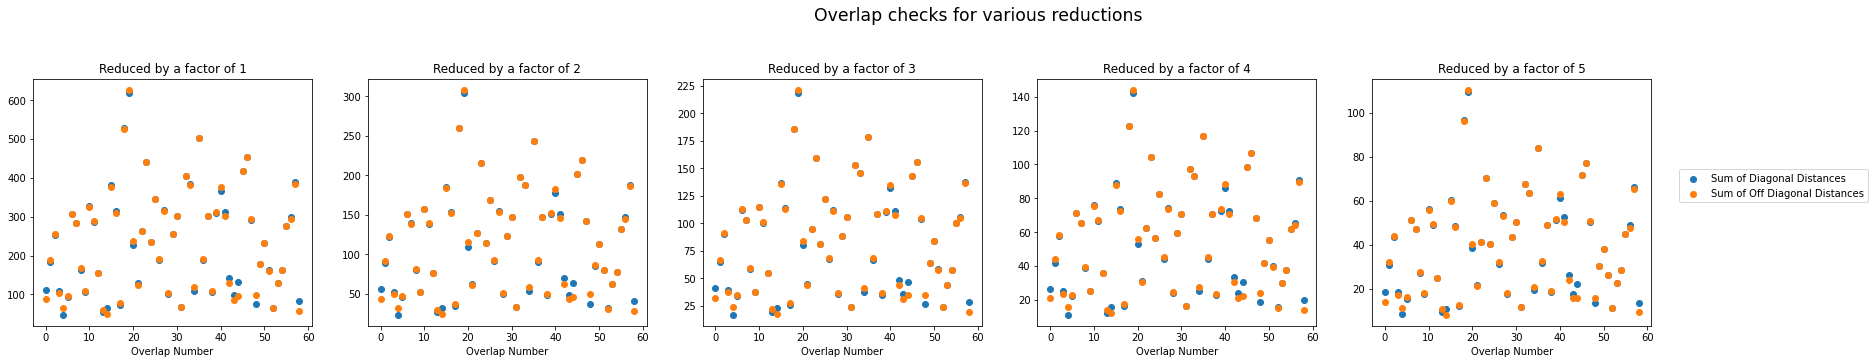

Difference Between Reductions of: 1 2 Difference: set() Error: 0.0
Difference Between Reductions of: Manual 2 Difference: {10, 16, 18, 22, 23, 24, 26, 27, 29, 35, 40, 42, 45, 52, 53, 55} Error: 0.6956521739130435
Difference Between Reductions of: 1 3 Difference: {7, 12, 24} Error: 0.09090909090909091
Difference Between Reductions of: Manual 3 Difference: {7, 10, 12, 16, 18, 22, 23, 26, 27, 29, 35, 40, 42, 45, 52, 53, 55} Error: 0.7391304347826086
Difference Between Reductions of: 1 4 Difference: {25} Error: 0.030303030303030304
Difference Between Reductions of: Manual 4 Difference: {10, 16, 18, 22, 23, 24, 25, 26, 27, 29, 35, 40, 42, 45, 52, 53, 55} Error: 0.7391304347826086
Difference Between Reductions of: 1 5 Difference: {23, 50} Error: 0.06060606060606061
Difference Between Reductions of: Manual 5 Difference: {10, 16, 18, 22, 24, 26, 27, 29, 35, 40, 42, 45, 50, 52, 53, 55} Error: 0.6956521739130435
Difference Between Nonreduced and Manual: {10, 16, 18, 22, 23, 24, 26, 27, 29, 35, 4

In [60]:
histThing(histSumList,binsSum,5)

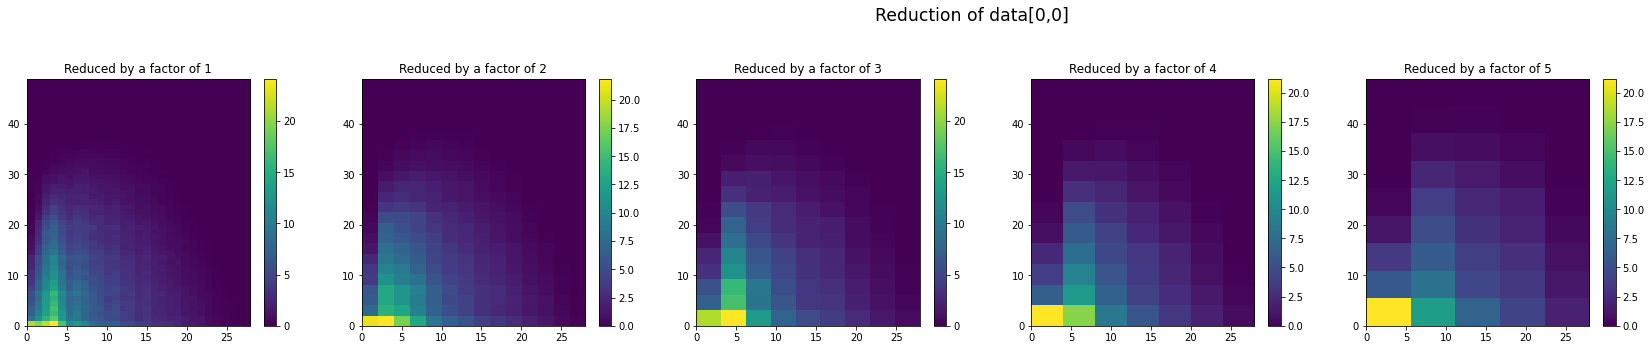

The overlaps for a reduction of 1 are [0, 3, 7, 8, 9, 10, 12, 14, 15, 21, 22, 23, 26, 29, 30, 32, 33, 40, 41, 42, 44, 45, 50, 51, 53, 54, 55, 56, 57, 58]
The overlaps for a reduction of 2 are [0, 3, 7, 8, 9, 10, 12, 14, 15, 16, 21, 22, 23, 26, 29, 30, 32, 33, 37, 40, 41, 42, 44, 45, 50, 51, 53, 54, 55, 56, 57, 58]
The overlaps for a reduction of 3 are [0, 3, 7, 8, 9, 10, 12, 14, 15, 16, 21, 22, 23, 26, 29, 30, 32, 33, 37, 40, 41, 42, 44, 45, 50, 51, 53, 54, 55, 56, 57, 58]
The overlaps for a reduction of 4 are [0, 3, 7, 8, 9, 10, 12, 14, 15, 16, 21, 22, 23, 26, 29, 30, 32, 33, 37, 40, 41, 42, 44, 45, 50, 53, 54, 55, 56, 57, 58]
The overlaps for a reduction of 5 are [0, 3, 7, 8, 9, 10, 12, 14, 15, 19, 21, 22, 23, 26, 29, 30, 32, 33, 35, 37, 40, 41, 42, 44, 45, 50, 53, 54, 55, 56, 57, 58]


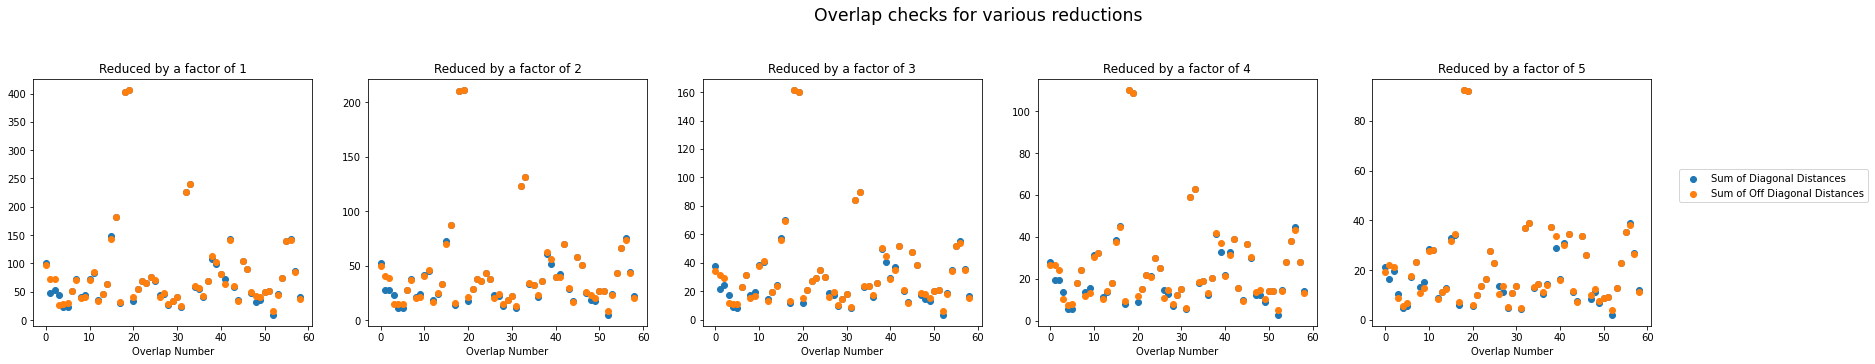

Difference Between Reductions of: 1 2 Difference: {16, 37} Error: 0.06666666666666667
Difference Between Reductions of: Manual 2 Difference: {8, 9, 10, 16, 22, 23, 25, 29, 37, 42, 43, 45, 55} Error: 0.5652173913043478
Difference Between Reductions of: 1 3 Difference: {16, 37} Error: 0.06666666666666667
Difference Between Reductions of: Manual 3 Difference: {8, 9, 10, 16, 22, 23, 25, 29, 37, 42, 43, 45, 55} Error: 0.5652173913043478
Difference Between Reductions of: 1 4 Difference: {16, 37, 51} Error: 0.1
Difference Between Reductions of: Manual 4 Difference: {8, 9, 10, 16, 22, 23, 25, 29, 37, 42, 43, 45, 51, 55} Error: 0.6086956521739131
Difference Between Reductions of: 1 5 Difference: {19, 35, 37, 51} Error: 0.13333333333333333
Difference Between Reductions of: Manual 5 Difference: {8, 9, 10, 19, 22, 23, 25, 29, 35, 37, 42, 43, 45, 51, 55} Error: 0.6521739130434783
Difference Between Nonreduced and Manual: {8, 9, 10, 22, 23, 25, 29, 42, 43, 45, 55} Error: 0.4782608695652174


In [61]:
histThing(histDifList,binsDif,5)

Create function that  takes everything in previous 2 sections and returns a histogram and some error info